In [1]:
import os
import sqlite3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import shap






IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# Function to load data from SQLite database
def load_from_db(db_name, table_name):
    conn = sqlite3.connect(db_name)
    query = f'SELECT * FROM {table_name}'
    df = pd.read_sql(query, conn)
    conn.close()

    return df

In [3]:
# Set working directory to the notebook's directory
os.chdir(r"C:\Users\DELL\OneDrive\Desktop\SCHOOL\team24_ly\team24_ly")

# Now define your base directory relative to this location
base_dir = os.path.abspath(os.path.join(os.getcwd(), 'data'))
db_name = os.path.join(base_dir, 'streetcardelaydb.db')

print(f"Database path: {db_name}")

# Check if the database file exists
if not os.path.exists(db_name):
    raise FileNotFoundError(f"Database file not found: {db_name}")

# Load data
table_name = 'Streetcar_Delay_Data'
df = load_from_db(db_name, table_name)


Database path: C:\Users\DELL\OneDrive\Desktop\SCHOOL\team24_ly\team24_ly\data\streetcardelaydb.db


In [4]:
# Convert incident_date to datetime format
df['incident_date'] = pd.to_datetime(df['incident_date'])

# Load Date table to get holidayType and isWeekend columns
date_table_name = 'Date'  
date_df = load_from_db(db_name, date_table_name)
date_df['date'] = pd.to_datetime(date_df['date'])

# Merge Date table with Streetcar_Delay_Data table on incident_date
df = df.merge(date_df[['date', 'holidayType', 'isWeekend']], left_on='incident_date', right_on='date', how='left')
df.drop(columns=['date'], inplace=True)

# Load Season table to get seasonType column
season_table_name = 'Season'  
season_df = load_from_db(db_name, season_table_name)
season_df['date'] = pd.to_datetime(season_df['date'])

# Merge Season table with Streetcar_Delay_Data table on incident_date
df = df.merge(season_df[['date', 'season']], left_on='incident_date', right_on='date', how='left')
df.rename(columns={'season': 'seasonType'}, inplace=True)  
df.drop(columns=['date'], inplace=True)

# Load Line table to get lineId and lineName (no lineType)
line_table_name = 'Line'  
line_df = load_from_db(db_name, line_table_name)

# Merge the dataframes on lineId
df = df.merge(line_df[['lineId', 'lineName']], left_on='line', right_on='lineId', how='left')

# Load Delay table to get delayType
delay_table_name = 'Delay'  
delay_df = load_from_db(db_name, delay_table_name)

# Function to determine delayType
def get_delay_type(min_delay):
    for _, row in delay_df.iterrows():
        if row['delayFrom'] <= min_delay <= row['delayTo']:
            return row['delayId']
    return None

# Apply the function to determine delayType
df['delayType'] = df['min_delay'].apply(get_delay_type)

# Display the DataFrame
df.head()


,incident_date,line,incident_time,day_of_week,location,incident,min_delay,min_gap,bound,vehicle,holidayType,isWeekend,seasonType,lineId,lineName,delayType
0,2023-01-01,505,02:40,Sunday,BROADVIEW AND GERRARD,Held By,15,25,W,4460,New Year's Day,yes,Winter 2023,505,Dundas,2
1,2023-01-01,504,02:52,Sunday,KING AND BATHURST,Cleaning - Unsanitary,10,20,W,4427,New Year's Day,yes,Winter 2023,504,King,2
2,2023-01-01,504,02:59,Sunday,KING AND BATHURST,Held By,25,35,E,4560,New Year's Day,yes,Winter 2023,504,King,3
3,2023-01-01,510,05:38,Sunday,SPADINA AND DUNDAS,Security,15,30,S,4449,New Year's Day,yes,Winter 2023,510,Spadina,2
4,2023-01-01,506,06:35,Sunday,OSSINGTON STATION,Security,10,20,None,8706,New Year's Day,yes,Winter 2023,506,Carlton,2


In [ ]:
# Display exploratory statistics
df.describe()

In [ ]:
# Assess datatype and any NULL values
df.info()

*Comment:*

-The dataset `df` contains 21,742 entries. 

1. **Null Values**:
   - Several columns contain null values:
     - `line` has 44 null values.
     - `location` has 1 null value.
     - `bound` has a significant number of null values (2,615).
     - `holidayType` has many null values, with only 502 non-null entries.
     - `lineId` and `lineName` also have null values (162 each).

2. **Data Types**:
   - `incident_date` is in `datetime64[ns]` format.
   - Integer columns include `min_delay`, `min_gap`, and `delayType`.
   - The rest are stored as `object`, which includes categorical or string data, like `bound`, `day_of_week`, and `vehicle`.

3. **Column Names and Non-Null Counts**:
   - This output can help identify where data cleaning might be necessary, such as handling the null values in `bound` and `holidayType`.



*Note:* 

- When TTC streetcars are out of service and buses are used as substitutes, these buses are typically assigned the same route number as the streetcar line they are replacing. This helps passengers easily identify the substitute service and understand that it follows the same route as the regular streetcar service.

- For example, if a streetcar on route 509 Harbourfront is out of service, a bus might be assigned route number 509 to continue providing service along the same path.

- Therefore, we can drop the null values in 'line'.


In [ ]:
# Count the unique values of each of the features
df.nunique()

In [ ]:
# Let's see why 'bound' has 8 unique values when it should only have 4 (N, S, W, E)
df['bound'].unique()


In [5]:
# Define the allowed values
allowed_bounds = ['N', 'S', 'W', 'E']

# Filter the DataFrame to keep only rows where 'bound' is in the allowed list
df = df[df['bound'].isin(allowed_bounds)]

# Reset the index if needed
df.reset_index(drop=True, inplace=True)

# Display the filtered DataFrame
df['bound'].unique()


array(['W', 'E', 'S', 'N'], dtype=object)

In [6]:
# Drop rows with null values in any column except 'holidayType'
df = df.dropna(subset=[col for col in df.columns if col != 'holidayType'])

# Confirm the remaining rows and null counts
print(df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 18985 entries, 0 to 19108
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   incident_date  18985 non-null  datetime64[ns]
 1   line           18985 non-null  object        
 2   incident_time  18985 non-null  object        
 3   day_of_week    18985 non-null  object        
 4   location       18985 non-null  object        
 5   incident       18985 non-null  object        
 6   min_delay      18985 non-null  int64         
 7   min_gap        18985 non-null  int64         
 8   bound          18985 non-null  object        
 9   vehicle        18985 non-null  object        
 10  holidayType    436 non-null    object        
 11  isWeekend      18985 non-null  object        
 12  seasonType     18985 non-null  object        
 13  lineId         18985 non-null  object        
 14  lineName       18985 non-null  object        
 15  delayType      18985 non

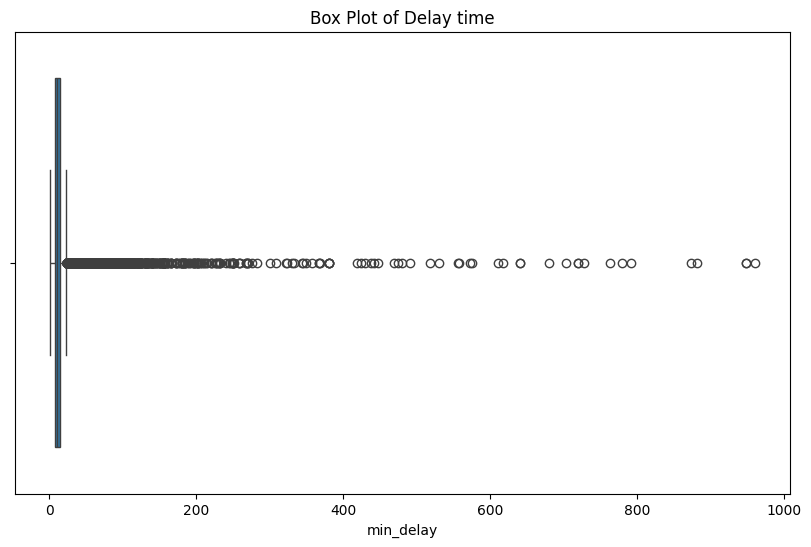

In [7]:
# Check for class imbalance with data visualization tools.

# Whisker plot 
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['min_delay'])
plt.title('Box Plot of Delay time')
plt.show()

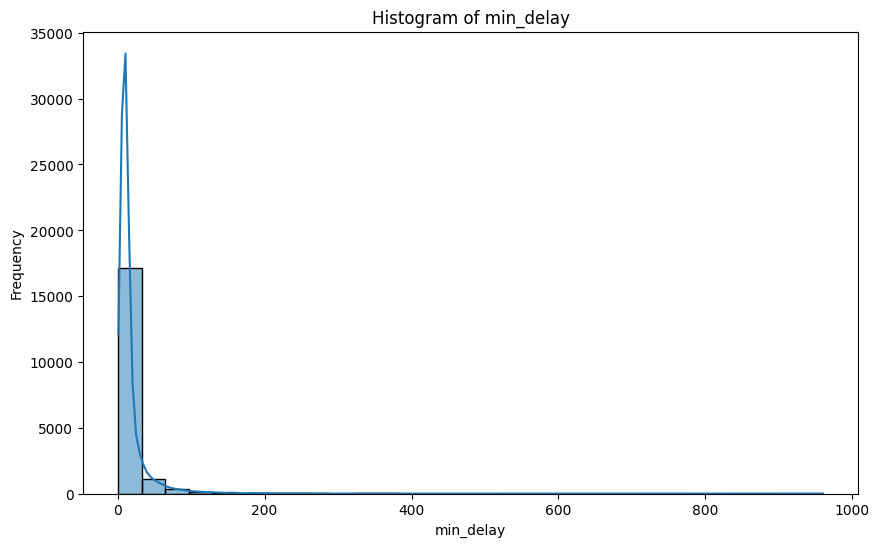

In [8]:
# Histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['min_delay'], bins=30, kde=True)
plt.title('Histogram of min_delay')
plt.xlabel('min_delay')
plt.ylabel('Frequency')
plt.show()

In [ ]:
df['min_delay'].nlargest(20)


In [ ]:
# Filter the DataFrame for min_delay values for thresholds
df_delay_16_plus = df[df['min_delay'] >= 16]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_delay_16_plus['min_delay'], bins=100, color='skyblue', edgecolor='black')
plt.title('Histogram of min_delay (above 15 minutes)')
plt.xlabel('Delay in Minutes')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# Filter the DataFrame for min_delay values for thresholds
df_delay_16_to_60 = df[(df['min_delay'] >= 16) & (df['min_delay'] <= 60)]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_delay_16_to_60['min_delay'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of min_delay (16 minutes to 1 hour)')
plt.xlabel('Delay in Minutes')
plt.ylabel('Frequency')
plt.show()


*Observation:*

- Frequency drops from about 600 instances for 20-minute delays, to less than 300 instances for 30-minute delays, to about 100 instances for each of 40-minute delays, 50-minute delays, and 60 minute delays. 



In [ ]:
# Filter the DataFrame for min_delay values for thresholds
df_delay_61_to_90 = df[(df['min_delay'] >= 61) & (df['min_delay'] <= 90)]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_delay_61_to_90['min_delay'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of min_delay (1 to 1.5 hours)')
plt.xlabel('Delay in Minutes')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Filter the DataFrame for min_delay values for thresholds
df_delay_above_90 = df[(df['min_delay'] >= 91)]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_delay_above_90['min_delay'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of min_delay (above 1.5 hours)')
plt.xlabel('Delay in Minutes')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Filter the DataFrame for min_delay values for thresholds
df_delay_above_300 = df[(df['min_delay'] >= 301)]

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_delay_above_300['min_delay'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of min_delay (above 5 hours)')
plt.xlabel('Delay in Minutes')
plt.ylabel('Frequency')
plt.show()

*Comment:*

- We will remove instances where the delays are more than 5 hours. 

In [9]:
# Create a new DataFrame with min_delay values of 300 minutes or more - for later studies
df_delay_over_5hr = df[df['min_delay'] >= 300]

# Display the new DataFrame
df_delay_over_5hr.head()



,incident_date,line,incident_time,day_of_week,location,incident,min_delay,min_gap,bound,vehicle,holidayType,isWeekend,seasonType,lineId,lineName,delayType
170,2023-01-08,506,04:44,Sunday,COLLEGE AND GRACE,Diversion,763,773,E,4545,None,yes,Winter 2023,506,Carlton,3
1020,2023-02-07,501,11:25,Tuesday,QUEEN AND GLADSTONE,Diversion,575,581,W,4472,None,no,Winter 2023,501,Queen,3
2052,2023-03-15,501,06:45,Wednesday,585 QUEEN ST,Diversion,323,331,E,4459,None,no,Winter 2023,501,Queen,3
3018,2023-04-15,509,07:11,Saturday,QUEENS QUAY AND LOWER,Diversion,720,728,W,1127,None,yes,Spring 2023,509,Harbourfront,3
3021,2023-04-15,510,10:48,Saturday,SPADINA BW KING TO QUE,Diversion,419,423,S,4574,None,yes,Spring 2023,510,Spadina,3


In [10]:
# Create a new DataFrame with min_delay values less than 300 minutes
df_new = df[df['min_delay'] < 300]

# Display the new DataFrame
df_new.head()



,incident_date,line,incident_time,day_of_week,location,incident,min_delay,min_gap,bound,vehicle,holidayType,isWeekend,seasonType,lineId,lineName,delayType
0,2023-01-01,505,02:40,Sunday,BROADVIEW AND GERRARD,Held By,15,25,W,4460,New Year's Day,yes,Winter 2023,505,Dundas,2
1,2023-01-01,504,02:52,Sunday,KING AND BATHURST,Cleaning - Unsanitary,10,20,W,4427,New Year's Day,yes,Winter 2023,504,King,2
2,2023-01-01,504,02:59,Sunday,KING AND BATHURST,Held By,25,35,E,4560,New Year's Day,yes,Winter 2023,504,King,3
3,2023-01-01,510,05:38,Sunday,SPADINA AND DUNDAS,Security,15,30,S,4449,New Year's Day,yes,Winter 2023,510,Spadina,2
4,2023-01-01,501,08:52,Sunday,LAKE SHORE AND THIRTY,Cleaning - Unsanitary,10,20,W,8015,New Year's Day,yes,Winter 2023,501,Queen,2


In [ ]:
df_new.describe()

In [ ]:
df_new.info()

In [11]:
# Convert incident_time to datetime format, inferring time format
df_new['incident_time'] = pd.to_datetime(df_new['incident_time'], errors='coerce').dt.time

# Define function to categorize time
def categorize_time(time):
    if pd.isna(time):
        return None
    if pd.to_datetime('06:30').time() <= time <= pd.to_datetime('09:30').time():
        return 'morning_peak'
    elif pd.to_datetime('10:00').time() <= time <= pd.to_datetime('14:00').time():
        return 'midday'
    elif pd.to_datetime('16:30').time() <= time <= pd.to_datetime('19:00').time():
        return 'evening_peak'
    else:
        return 'off_peak'

# Apply function to create new column "timeType"
df_new['timeType'] = df_new['incident_time'].apply(categorize_time)

# Clean columns: location, bound, incident, vehicle, day_of_week
# Define a helper function for cleaning columns
def clean_column(df, column_name, valid_values=None):
    # Remove leading and trailing spaces
    df[column_name] = df[column_name].str.strip()
    
    # Drop null values
    df = df.dropna(subset=[column_name])
    
    # If valid values are provided, filter the dataframe
    if valid_values:
        df = df[df[column_name].isin(valid_values)]
    
    return df

# Initialize df_cleaned to be a copy of df_new
df_cleaned = df_new.copy()

# Apply the function to each column that needs cleaning
df_cleaned = clean_column(df_cleaned, 'location')
df_cleaned = clean_column(df_cleaned, 'incident')
df_cleaned = clean_column(df_cleaned, 'vehicle')
df_cleaned = clean_column(df_cleaned, 'day_of_week')
df_cleaned = clean_column(df_cleaned, 'line')
df_cleaned = clean_column(df_cleaned, 'bound')

# One-Hot Encode Categorical Columns

# Identify categorical columns that need to be one-hot encoded
categorical_cols = ['location', 'incident', 'vehicle', 'day_of_week', 'line', 'bound', 'timeType', 'holidayType', 'isWeekend', 'seasonType']

# Use pandas get_dummies to one-hot encode the categorical columns
df_cleaned = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)

# Display the DataFrame after one-hot encoding
df_cleaned.head()


Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,incident_date,incident_time,min_delay,min_gap,lineId,lineName,delayType,location_1 DAVIES AVE,location_10 RITCHIE AVE,location_100 KING ST W,...,holidayType_Thanksgiving,holidayType_Victoria Day,isWeekend_yes,seasonType_Fall 2024,seasonType_Spring 2023,seasonType_Spring 2024,seasonType_Summer 2023,seasonType_Summer 2024,seasonType_Winter 2023,seasonType_Winter 2024
0,2023-01-01,02:40:00,15,25,505,Dundas,2,False,False,False,...,False,False,True,False,False,False,False,False,True,False
1,2023-01-01,02:52:00,10,20,504,King,2,False,False,False,...,False,False,True,False,False,False,False,False,True,False
2,2023-01-01,02:59:00,25,35,504,King,3,False,False,False,...,False,False,True,False,False,False,False,False,True,False
3,2023-01-01,05:38:00,15,30,510,Spadina,2,False,False,False,...,False,False,True,False,False,False,False,False,True,False
4,2023-01-01,08:52:00,10,20,501,Queen,2,False,False,False,...,False,False,True,False,False,False,False,False,True,False


In [12]:
print(df_cleaned.dtypes)  # This should show only numeric data types



incident_date             datetime64[ns]
incident_time                     object
min_delay                          int64
min_gap                            int64
lineId                            object
                               ...      
seasonType_Spring 2024              bool
seasonType_Summer 2023              bool
seasonType_Summer 2024              bool
seasonType_Winter 2023              bool
seasonType_Winter 2024              bool
Length: 4494, dtype: object


In [13]:
# Save column data types to a text file
with open("data_types_output.txt", "w") as file:
    file.write(df_cleaned.dtypes.to_string())


In [ ]:
df_cleaned.describe()

In [15]:
# Drop the following columns: incident_date, incident_time, min_gap, lineID. min_delay
df_cleaned = df_cleaned.drop(['incident_date','incident_time', 'min_gap', 'lineId', 'lineName'], axis=1)


In [ ]:
# Check the distribution of delayType
print(df_cleaned['delayType'].value_counts())

In [ ]:
# Visualize this with a whisker plot:
delay_type_counts = df_cleaned['delayType'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=delay_type_counts.index, y=delay_type_counts.values, palette='viridis')
plt.title('Distribution of Delay Types')
plt.xlabel('Delay Type')
plt.ylabel('Count')
plt.show()


In [16]:
# Define X and y: 
X = df_cleaned.drop(columns=['min_delay', 'delayType']) 
y = df_cleaned['delayType']

# PAUSE HERE - TO CONTINUE AFTER LUNCH

In [17]:
# Save column data types to a text file
with open("X_data_types_output.txt", "w") as file:
    file.write(X.dtypes.to_string())

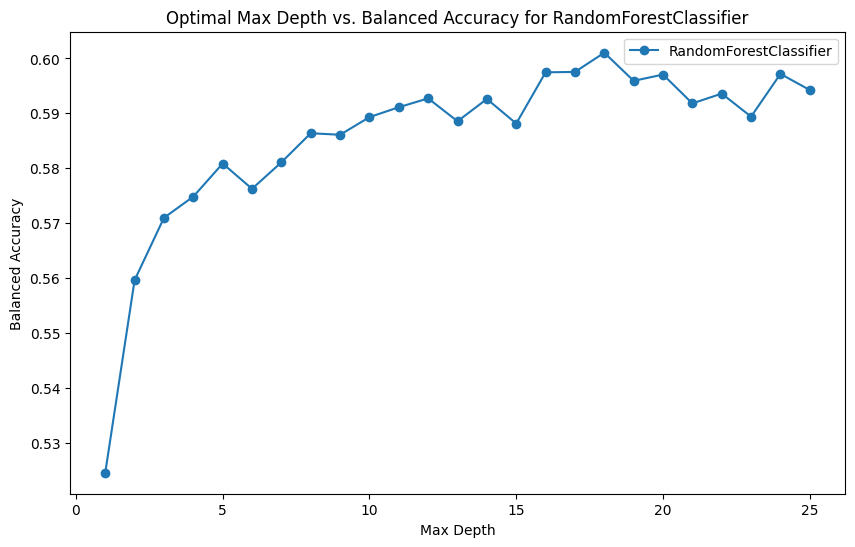

In [20]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Step 1: Split data into training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Convert y_train to integer if it’s categorical
y_train = y_train.astype(int)

# Step 2: Set up stratified cross-validation on the training set
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Step 3: Tune max_depth on the training set using stratified cross-validation
max_depth_range = range(1, 26)
balanced_accuracy_depth = []

for max_depth in max_depth_range:
    rf_temp = RandomForestClassifier(max_depth=max_depth, class_weight='balanced', random_state=42)
    # Perform cross-validation with balanced accuracy scoring
    scores = cross_val_score(rf_temp, X_train, y_train, cv=stratified_cv, scoring='balanced_accuracy')
    mean_score = scores.mean()
    balanced_accuracy_depth.append(mean_score)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, balanced_accuracy_depth, label="RandomForestClassifier", marker='o')
plt.title("Optimal Max Depth vs. Balanced Accuracy for RandomForestClassifier")
plt.xlabel("Max Depth")
plt.ylabel("Balanced Accuracy")
plt.legend()
plt.show()


*Note:*

1. **`class_weight='balanced'`**: This adjustment helps the model **learn better from the minority classes** by applying a higher weight to underrepresented classes during training. This step ensures that the model does not ignore these classes simply because they are less frequent.

2. **`balanced_accuracy` as a Scoring Metric**: Even with `class_weight='balanced'`, using `balanced_accuracy` for evaluation remains useful. Provide an **evaluation metric that reflects balanced performance** across the delayTypes, preventing the model from being overly influenced by the majority class.  

*Interpretation:*

- Optimal max-depth value is between 17 and 19 (inclusive)

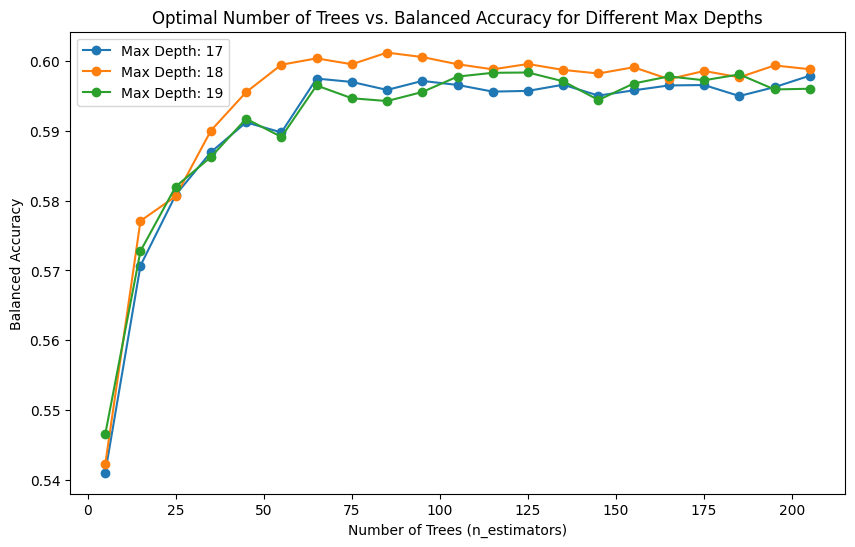

In [21]:
# Tune both max_depth and n_estimators on the training set using stratified cross-validation
max_depth_range = [17, 18, 19]  # Limited max_depth range for faster tuning
n_estimators_range = range(5, 210, 10)  # Range for n_estimators
results = []  # To store results for each combination

for max_depth in max_depth_range:
    balanced_accuracy_scores = []
    for n_estimators in n_estimators_range:
        rf_temp = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, class_weight='balanced', random_state=42)
        # Perform cross-validation with balanced accuracy scoring
        scores = cross_val_score(rf_temp, X_train, y_train, cv=stratified_cv, scoring='balanced_accuracy')
        mean_score = scores.mean()
        balanced_accuracy_scores.append(mean_score)
    
    # Store results for this max_depth
    results.append((max_depth, balanced_accuracy_scores))

# Plot the results for each max_depth
plt.figure(figsize=(10, 6))
for max_depth, scores in results:
    plt.plot(n_estimators_range, scores, label=f"Max Depth: {max_depth}", marker='o')

plt.title("Optimal Number of Trees vs. Balanced Accuracy for Different Max Depths")
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Balanced Accuracy")
plt.legend()
plt.show()


*Observation:*
= The optimal number of 'n' is about 50 - 90 trees, and optimal max-depth value of 18. 

In [26]:
# Define the parameter grid with max_depth fixed at 18
param_grid = {
    'n_estimators': [50, 75, 90],  # Number of trees in the forest
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# Initialize the Random Forest Classifier with fixed max_depth
clf = RandomForestClassifier(max_depth=18, class_weight='balanced', random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=clf,  # The Random Forest Classifier with fixed max_depth
    param_grid=param_grid,  # The parameter grid for tuning
    cv=5,  # Number of cross-validation folds
    scoring='balanced_accuracy',  # Scoring metric to evaluate the model's performance
    n_jobs=-1  # Use all available CPU cores for computation
)

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)


Best parameters found:  {'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 90}


In [27]:
best_params = {
    'n_estimators': 90,  # Number of trees in the forest
    'min_samples_leaf': 1,  # Minimum number of samples required to be at a leaf node
    'min_samples_split': 10,  # Minimum number of samples required to split an internal node
    'max_depth': 18  # Minimum number of samples required to split an internal node
}

# Initialize and fit the Random Forest Classifier with updated best parameters
best_clf = RandomForestClassifier(**best_params, class_weight='balanced', random_state=42)
best_clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=18,
                       min_samples_split=10, n_estimators=90, random_state=42)

In [29]:
# Get the feature importances
feature_importances = best_clf.feature_importances_

# Use the feature names from the preprocessed data
features = X.columns  # Get all the feature names from the DataFrame after preprocessing

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


                                Feature  Importance
2905                 incident_Diversion    0.129813
4464                           line_512    0.088714
2911                incident_Mechanical    0.030141
2904  incident_Collision - TTC Involved    0.029992
4470                  timeType_off_peak    0.025630
...                                 ...         ...
1795    location_OSSINGTON AND UNIVERSI    0.000000
1798       location_PALIAMENT AND FRONT    0.000000
1799         location_PAPE AND DANFORTH    0.000000
1800          location_PAPE AND GERRARD    0.000000
2243        location_QUEENA AND NEVILLE    0.000000

[4487 rows x 2 columns]


In [31]:
from sklearn.metrics import classification_report, balanced_accuracy_score

# Generate the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Calculate and print the balanced accuracy score
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy: {balanced_acc:.2f}")


Classification Report:
               precision    recall  f1-score   support

           1       0.29      0.62      0.39       583
           2       0.80      0.57      0.67      3832
           3       0.45      0.60      0.52      1266

    accuracy                           0.59      5681
   macro avg       0.51      0.60      0.53      5681
weighted avg       0.67      0.59      0.61      5681


Balanced Accuracy: 0.60


In [32]:
import shap

# Create a SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(best_clf)

# Calculate SHAP values
# For classifiers, shap_values is a list of arrays (one per class)
shap_values = explainer.shap_values(X_test)


In [33]:
# SHAP values for delayType = 1
shap_values_class1 = shap_values[0]

# SHAP values for delayType = 2
shap_values_class2 = shap_values[1]

# SHAP values for delayType = 3
shap_values_class3 = shap_values[2]


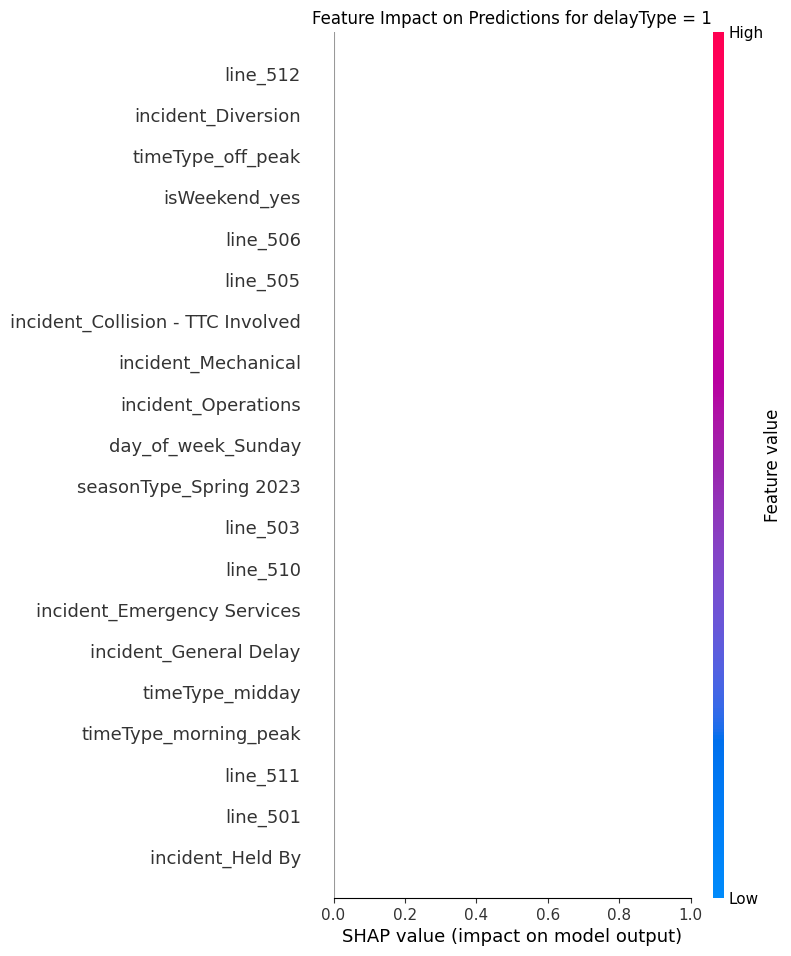

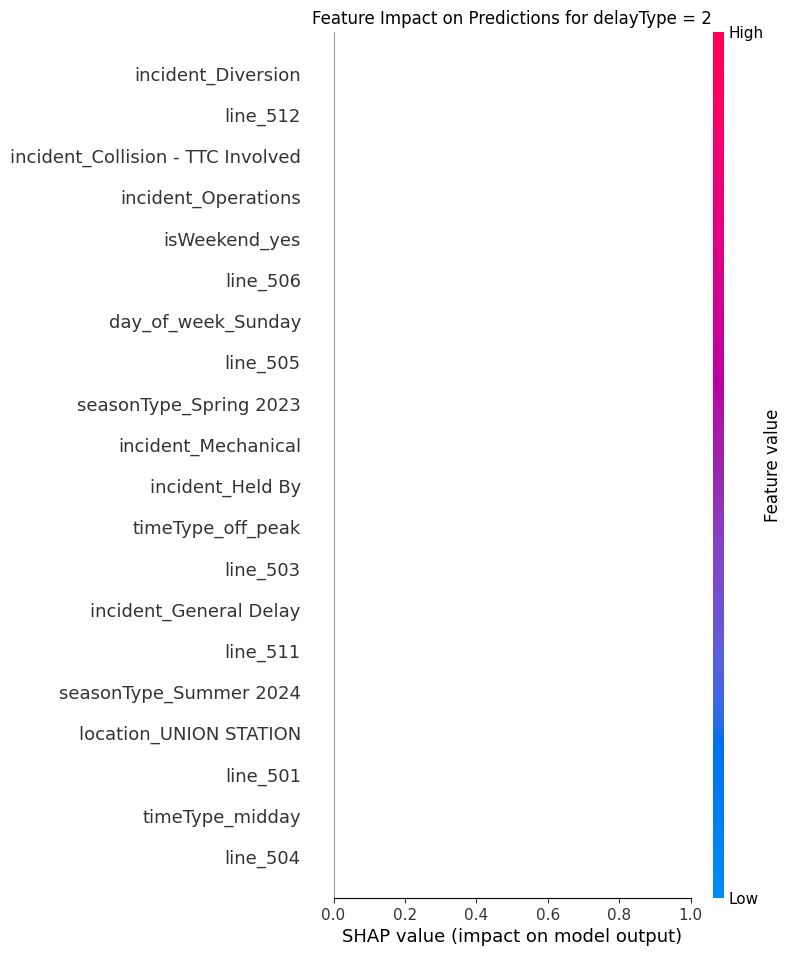

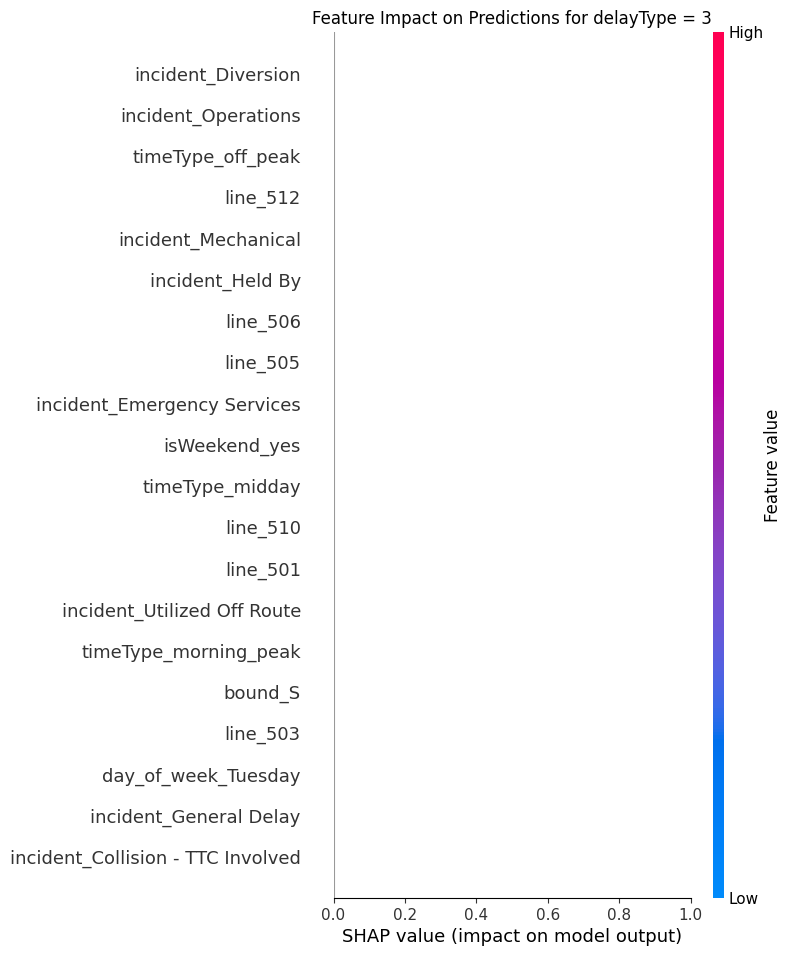

In [34]:
import matplotlib.pyplot as plt

# Beeswarm plot for delayType = 1
plt.figure()
shap.summary_plot(shap_values_class1, X_test, plot_type="beeswarm", show=False)
plt.title("Feature Impact on Predictions for delayType = 1")
plt.show()

# Beeswarm plot for delayType = 2
plt.figure()
shap.summary_plot(shap_values_class2, X_test, plot_type="beeswarm", show=False)
plt.title("Feature Impact on Predictions for delayType = 2")
plt.show()

# Beeswarm plot for delayType = 3
plt.figure()
shap.summary_plot(shap_values_class3, X_test, plot_type="beeswarm", show=False)
plt.title("Feature Impact on Predictions for delayType = 3")
plt.show()


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


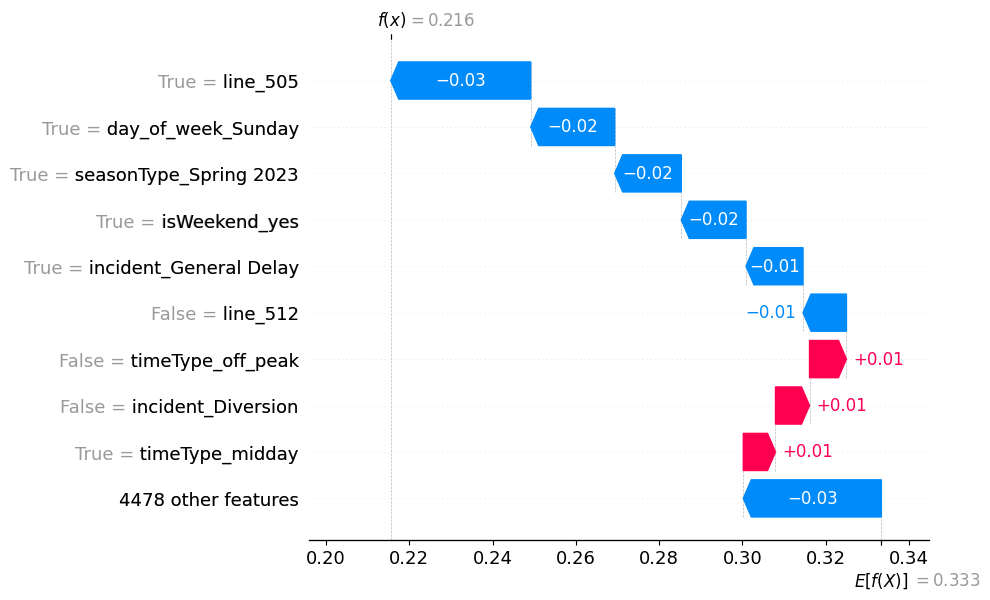

In [35]:
# Sample index for demonstration
sample_index = 0

# Waterfall plot for delayType = 1
shap.waterfall_plot(shap.Explanation(values=shap_values_class1[sample_index],
                                     base_values=explainer.expected_value[0],
                                     data=X_test.iloc[sample_index],
                                     feature_names=X_test.columns))

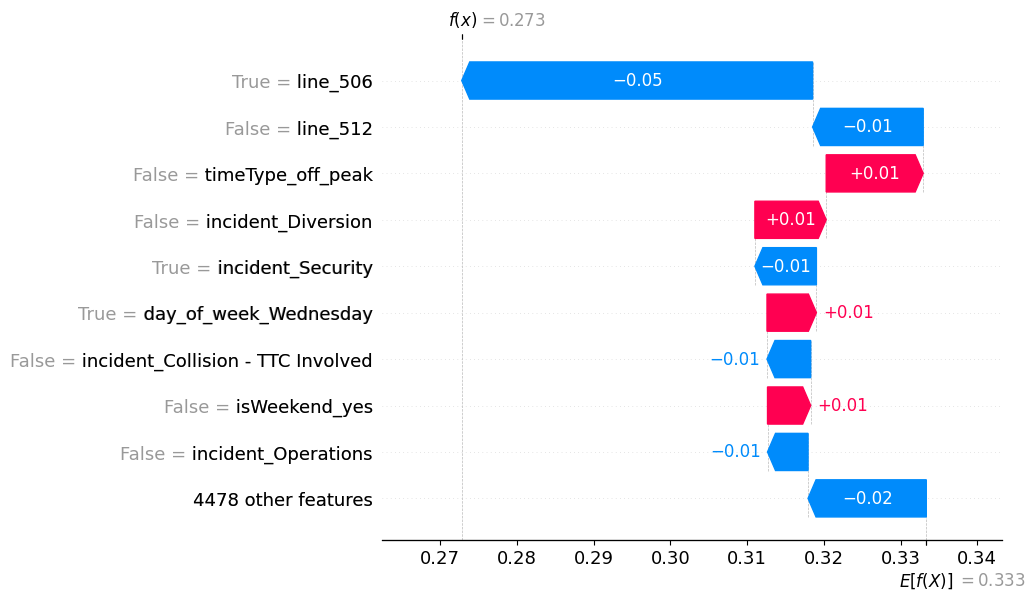

In [36]:
# Sample index for demonstration
sample_index = 1

# Waterfall plot for delayType = 1
shap.waterfall_plot(shap.Explanation(values=shap_values_class1[sample_index],
                                     base_values=explainer.expected_value[0],
                                     data=X_test.iloc[sample_index],
                                     feature_names=X_test.columns))

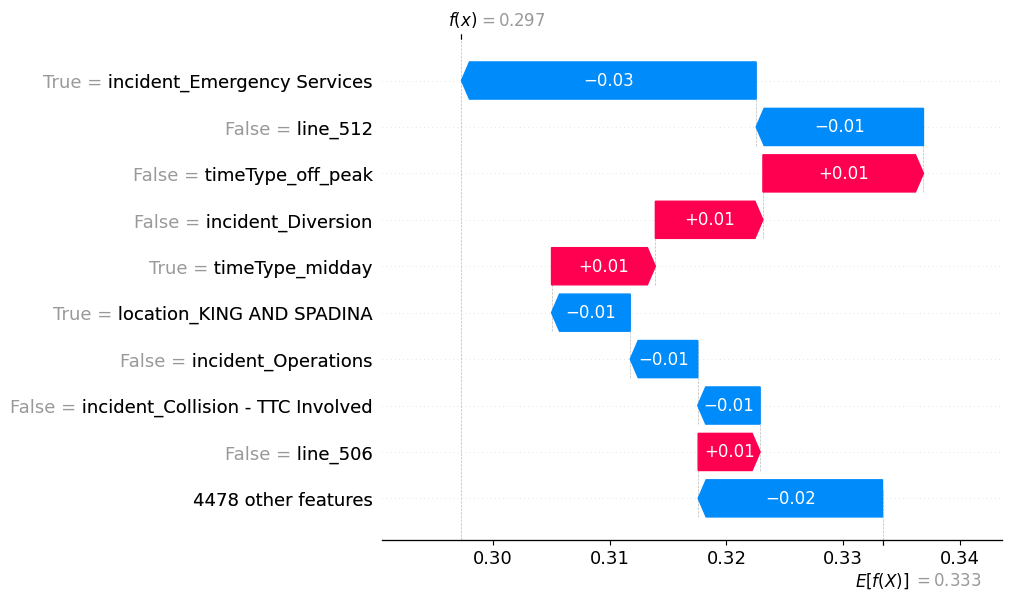

In [37]:
# Sample index for demonstration
sample_index = 3

# Waterfall plot for delayType = 1
shap.waterfall_plot(shap.Explanation(values=shap_values_class1[sample_index],
                                     base_values=explainer.expected_value[0],
                                     data=X_test.iloc[sample_index],
                                     feature_names=X_test.columns))

In [ ]:
'''
# Finding Optimal Parameters for RandomForestClassifier using RandomizedSearchCV
rf = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': [50, 100, 150, 200, 250],
    'max_depth': range(1, 21),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10]
}
'''

In [ ]:
'''
random_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=20, cv=5, scoring='balanced_accuracy', random_state=42)
random_search.fit(X_train, y_train)
'''

In [ ]:
'''
# Extract the best parameters and model
best_rf_params = random_search.best_params_
best_rf_model = random_search.best_estimator_

# Print the best parameters found
print("Best Parameters for RandomForestClassifier (RandomizedSearchCV):")
print(best_rf_params)
'''

In [ ]:
'''
# Finding Optimal Parameters for RandomForestClassifier using Bayesian Optimization
rf_bayes = RandomForestClassifier(random_state=42)
param_space = {
    'n_estimators': (200, 300),
    'max_depth': (15, 25),
    'min_samples_split': (2, 5),
    'min_samples_leaf': (1, 3)
}
'''


In [ ]:
'''
bayes_search = BayesSearchCV(rf_bayes, search_spaces=param_space, n_iter=20, cv=5, scoring='balanced_accuracy', random_state=42)
bayes_search.fit(X_train, y_train)
'''

In [ ]:
'''
bayes_search = BayesSearchCV(rf_bayes, search_spaces=param_space, n_iter=20, cv=5, scoring='balanced_accuracy', random_state=42)
bayes_search.fit(X_train, y_train)
'''

In [ ]:
'''
# Extract the best parameters and model for Bayesian Optimization
best_rf_bayes_params = bayes_search.best_params_
best_rf_bayes_model = bayes_search.best_estimator_

# Print the best parameters found for Bayesian Optimization
print("Best Parameters for RandomForestClassifier (Bayesian Optimization):")
print(best_rf_bayes_params)
'''

In [ ]:
'''
*Comment:*

### In Theory: 
- In theory, the Randomized Search CV is the 'industry practice' for finding optimal parameters before hyperparameter-tuning the model further with Bayesian Optimization. 
- The Randomized Searched CV produces 'global optimal' parameters for the Random Forest Classifier as 250 trees, and max-depth value of 20. On my laptop, it ran for almost 10 minutes. 

### In Practice: 
- However, as we saw on the earlier graphs: this significant increment in numbers of trees and max-depth values will contribute very little to the model's performance - barely 1% improvement - but will only tax the computational costs. 

### Verdict: 
- The optimal parameters choice is one that is efficient and fast. We also want to avoid underfitting with such a low set of values, as well as avoid overfitting with large values. Therefore, we will choose max-depth value of 5, and 'n' number of trees to be 20. 
'''

In [ ]:
# Define the parameter grid
param_grid = {
    'n_estimators': [10, 15, 20], # testing different numbers of trees in the forest: 50 trees, 100 trees, 200 trees. 
    'max_depth': [1, 5, 10], # preventing overfitting by limiting how deep the trees can grow: max 10 levels, 20 levels, 30 levels. 
    'min_samples_split': [2, 5, 10], # further reducing overfitting, by controlling the growth of the trees, by specifying the minimum number of samples required to split an internal node: allowing split even if only 2 samples are present, 5 samples are present, 10 samples are present. 
    'min_samples_leaf': [1, 2, 4] # further reducing overfitting, by controlling the size of the tree, by determining the minimum number of samples required to be at a leaf node: allowing leaves to contain 1 sample, 2 samples, 4 samples. 
}


In [ ]:
# Initialize the Random Forest Classifier
clf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
                    estimator=clf, # select "clf" (Random Forest Classifier - defined above) as the estimator. 
                    param_grid=param_grid, # defines the hyperparameters (defined in the cell above) and their possible values to be searched over. 
                    cv=5, # specifies the number of cross-validation folds to be used: 5. Ie. Split the data into 5 subsets, each taking turn as training set and validation set. The process is repeated 5 tiems. 
                    scoring='balanced_accuracy', # specifies the metric "accuracy" as the scoring metric to evaluate the model's performance. Accuracy is the ratio of correctly predicted instances to the total instances.
                    n_jobs=-1) # tells GridSearchCV to use all available CPU cores for computation, speeding up the computation process.

# Fit RandomizedSearchCV to the data
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)

In [ ]:
best_params = {
    'max_depth': 10,        # Value of max-depth
    'min_samples_leaf': 2,  # Minimum number of samples required to be at a leaf node
    'min_samples_split': 2,  # Minimum number of samples required to split an internal node
    'n_estimators': 20,     # Number of trees in the forest  
}

# Initialize and fit the Random Forest Classifier with updated best parameters
best_clf = RandomForestClassifier(**best_params, random_state=42)
best_clf.fit(X_train, y_train)

In [ ]:
# Fit the 
# clf.fit(X_train, y_train)


# Initialize and fit the Random Forest Classifier with best parameters
# best_clf = RandomForestClassifier(**best_params, random_state=42)
# best_clf.fit(X_train, y_train)

# Predicting the delay types using the trained model
y_pred = best_clf.predict(X_test)


In [ ]:
# Get the feature importances
feature_importances = best_clf.feature_importances_

# Use the feature names from the preprocessed data
features = X.columns  # Get all the feature names from the DataFrame after preprocessing

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


In [ ]:
# Run the evaluation on the model's performance with custom labels
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

In [ ]:
print("Training set class distribution:")
print(pd.Series(y_train).value_counts())

print("\nTest set class distribution:")
print(pd.Series(y_test).value_counts())


In [ ]:
best_clf = RandomForestClassifier(**best_params, random_state=42, class_weight='balanced')
best_clf.fit(X_train, y_train)


In [ ]:
# Predicting the delay types using the trained model
y_pred = best_clf.predict(X_test)

In [ ]:
# Get the feature importances
feature_importances = best_clf.feature_importances_

# Use the feature names from the preprocessed data
features = X.columns  # Get all the feature names from the DataFrame after preprocessing

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)


In [ ]:
# Run the evaluation on the model's performance with custom labels
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

In [ ]:
from sklearn.metrics import classification_report, balanced_accuracy_score

# Generate the classification report
class_report = classification_report(y_test, y_pred)
print("Classification Report:\n", class_report)

# Calculate and print the balanced accuracy score
balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"\nBalanced Accuracy: {balanced_acc:.2f}")


In [ ]:
import shap

# Create a SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(best_clf)

# Calculate SHAP values
# For classifiers, shap_values is a list of arrays (one per class)
shap_values = explainer.shap_values(X_test)


In [ ]:
# SHAP values for delayType = 1
shap_values_class1 = shap_values[0]

# SHAP values for delayType = 2
shap_values_class2 = shap_values[1]

# SHAP values for delayType = 3
shap_values_class3 = shap_values[2]


In [ ]:
import matplotlib.pyplot as plt

# Beeswarm plot for delayType = 1
plt.figure()
shap.summary_plot(shap_values_class1, X_test, plot_type="beeswarm", show=False)
plt.title("Feature Impact on Predictions for delayType = 1")
plt.show()

# Beeswarm plot for delayType = 2
plt.figure()
shap.summary_plot(shap_values_class2, X_test, plot_type="beeswarm", show=False)
plt.title("Feature Impact on Predictions for delayType = 2")
plt.show()

# Beeswarm plot for delayType = 3
plt.figure()
shap.summary_plot(shap_values_class3, X_test, plot_type="beeswarm", show=False)
plt.title("Feature Impact on Predictions for delayType = 3")
plt.show()


In [ ]:
# Sample index for demonstration
sample_index = 0

# Waterfall plot for delayType = 1
shap.waterfall_plot(shap.Explanation(values=shap_values_class1[sample_index],
                                     base_values=explainer.expected_value[0],
                                     data=X_test.iloc[sample_index],
                                     feature_names=X_test.columns))


In [ ]:
# Sample index for demonstration
sample_index = 1

# Waterfall plot for delayType = 1
shap.waterfall_plot(shap.Explanation(values=shap_values_class1[sample_index],
                                     base_values=explainer.expected_value[1],
                                     data=X_test.iloc[sample_index],
                                     feature_names=X_test.columns))


In [ ]:
# Sample index for demonstration
sample_index = 2

# Waterfall plot for delayType = 1
shap.waterfall_plot(shap.Explanation(values=shap_values_class1[sample_index],
                                     base_values=explainer.expected_value[2],
                                     data=X_test.iloc[sample_index],
                                     feature_names=X_test.columns))


In [ ]:
# Beeswarm plot for delayType = 1
shap.summary_plot(shap_values[0], X_test, plot_type="beeswarm")


In [ ]:
for i, shap_val in enumerate(shap_values):
    print(f"SHAP values summary for class {i + 1}:")
    print(pd.DataFrame(shap_val, columns=X_test.columns).describe())


In [ ]:
# Beeswarm plot for each delayType class
for i in range(len(shap_values)):
    plt.figure()
    shap.summary_plot(shap_values[i], X_test, plot_type="beeswarm")
    plt.title(f"Feature Impact on Predictions for delayType = {i + 1}")
    plt.show()


**INTERPRETATION:**

- **Accuracy:** **72%** of the predictions made by the model are correct.

- **Precision, Recall, and F1-score (ie. the harmonic mean of precision and recall):** 
    - delayType 1 (Short Delay Time: <=5 minutes): This class **performs poorly** on the recall score (16%), with many actual delayType 1 instances are not being predicted as delayType 1. 

    - delayType 2 (Expected Delay Time: 6-15 minutes): This class **performs well** with high scores across precision (73%), recall (93%), and f1 (82%).
       
    - delayType 3 (Long Delay Time: over 15 minutes ): This class **performs poorly** on the recall score (35%), with many actual delayType 3 instances are not being predicted as delayType 3. 



# 2) Evaluation - Comment:

Our predictive model gives acceptable performance on the accuracy score (72%) with 72% of the predictions made by this model are correct. 

The model also performs well for delayType 2 - the frequent delays type - across precision (73%), recall (93%) and F1 scores (82%). This class also significantly dominates the dataset. 

With these acceptable scores, we can rely on this model to achieve our business objective which is to find the most likely predictors of delay times, especially for the most frequently encountered delay type (delay between 6-15 minutes). 

For future studies, we recommend further analysis into other delay types - especially the Long Delay Type (delayType 3) for more targeted pre-emptive actions. 



    

In [ ]:
# print features name
print(X.columns)

# print numbers of features to make sure they are correct
print(f"Number of features: {X.shape[1]}")

In [ ]:
# Filter for the top 20 most important features
top_20_features = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Feature Importance Graph
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Importance', y='Feature', data=top_20_features, palette='viridis')

# Annotate the bar plot with the importance values
for index, value in enumerate(top_20_features['Importance']):
    barplot.text(value, index, f'{value:.2f}', color='black', ha="left", va='center')

plt.title('Top 20 Feature Importance Ranking')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [ ]:
''' 
# Define Base Models for Stacking
rf_classifier = RandomForestClassifier(random_state=42, max_depth=10, n_estimators=100)
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, max_depth=6, n_estimators=100, learning_rate=0.1)

# Meta-Learner
meta_learner = LogisticRegression()
'''

In [ ]:
'''
# Stacking Classifier
stacking_classifier = StackingClassifier(
    estimators=[('rf', rf_classifier), ('xgb', xgb_classifier)],
    final_estimator=meta_learner,
    cv=5
)
'''

In [ ]:
'''
# Pipeline with Stacking Classifier
stacking_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', stacking_classifier)
])
'''

In [ ]:
# Preprocessor 1: Standard scaling + One-Hot Encoding
preproc = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),                                
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])





In [ ]:
# Define baseline and advanced regressors
bag_clf = RandomForestClassifier(random_state=42)
boost_clf = XGBClassifier(random_state=42)

In [ ]:
# Pipeline A - Random Forest Classifier
pipeline_A = Pipeline([
    ('preprocessing', preproc),
    ('classifier', bag_clf)
])

In [ ]:
# Pipeline - XGBoost Classifier
pipeline_B = Pipeline([
    ('preprocessing', preproc),
    ('classifier', boost_clf)
])

In [ ]:
# Finding Optimal max_depth for RandomForestClassifier
max_depth_range = range(1, 21)
rf_temp = RandomForestClassifier(random_state=42)
errors_rf = []

In [ ]:
for depth in max_depth_range:
    rf_temp.set_params(max_depth=depth)
    scores = cross_val_score(rf_temp, X_train, y_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    errors_rf.append(mean_score)

In [ ]:
# Plot max_depth vs. Accuracy for RandomForestClassifier
plt.figure(figsize=(10, 6))
plt.plot(max_depth_range, errors_rf, label="RandomForestClassifier", marker='o')
plt.title("Max Depth vs. Accuracy for RandomForestClassifier")
plt.xlabel("Max Depth")
plt.ylabel("Cross-Validated Accuracy")
plt.legend()
plt.show()

*Observation:*
- Max depth is about less than 10 for the Random Forest Classifier.

In [ ]:
# Finding Optimal max_depth for XGBoost Classifier
xgb_temp = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_max_depth_range = range(1, 21)
errors_xgb = []

In [ ]:
for depth in xgb_max_depth_range:
    xgb_temp.set_params(max_depth=depth)
    scores = cross_val_score(xgb_temp, X_train, y_train, cv=5, scoring='accuracy')
    mean_score = scores.mean()
    errors_xgb.append(mean_score)

In [ ]:
# Preprocessing and Pipeline Setup
# Imputer and Scaler
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()

In [ ]:
# Finding Optimal Parameters for RandomForestClassifier
rf_temp = RandomForestClassifier(random_state=42)
max_depths = [None, 5, 10, 15, 20]
n_estimators = [50, 100, 150, 200]

In [ ]:
# Finding Optimal max_depth for RandomForestClassifier
max_depth_range = range(1, 21)
rf_temp = RandomForestClassifier(random_state=42)
errors_rf = []



In [ ]:
for depth in max_depth_range:
    rf_temp.set_params(max_depth=depth)
    scores = cross_val_score(rf_temp, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    mean_mae = -scores.mean()
    errors_rf.append(mean_mae)

